# Your favorite word embedding

<font color='red'>
    <br>
Put in the cells below your favorite "vectorized word embedding" and submit your notebook in the lms (word embedding section before midnight Thursday the 3rd).
</font>

In [419]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports

In [420]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

Some imports:

In [421]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf



!pip install tensorflow-addons

import tensorflow_addons as tfa

from keras.layers import Dense, Embedding, Flatten, Input, TextVectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow_addons.metrics import F1Score

In [422]:
!pip install gensim
from gensim.test.utils import datapath
from gensim import utils
import gensim.models

## Dataset

In [423]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

In [424]:
''' Construct X_train and y_train '''
X_train = TRAIN['Reviews'].fillna("")
y_train = np.array(TRAIN['Rating']).reshape(-1,1)

X_val = VAL['Reviews'].fillna("")
y_val = np.array(VAL['Rating']).reshape(-1,1)

X_test = TEST['Reviews'].fillna("")
y_test = np.array(TEST['Rating']).reshape(-1,1)


ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_enc = ohe.fit_transform(y_train)
y_val_enc = ohe.fit_transform(y_val)
y_test_enc = ohe.fit_transform(y_test)

X_train.shape, y_train_enc.shape, y_val_enc.shape, y_test_enc.shape

((5000,), (5000, 5), (1000, 5), (1000, 5))

## Word embedding and MLP classifier

First we need to convert data to numpy array:


In [425]:

#Convert train and test sets to numpy arrays:
X_train = np.asarray(X_train)
y_train_enc = np.asarray(y_train_enc)

X_val = np.asarray(X_val)
y_val_enc = np.asarray(y_val_enc)



### Constant definition


<font color='red'>
Use these constant names, you can of course change the value.
</font>

In [426]:
vocab_size = 500 # Vocab size
max_len = 100   # Sequence length to pad the outputs to.
embed_dim = 200 # embedding dimension
dense_dim = 128 # dense dimension
dropout_rate = 0.2 # Dropout rate
nb_classes = len(np.unique(y_train))

### Define Embedding Layer

<font color='red'>
$TO DO - Students$

* Define your embedding matrix or your vectorizer layer
    * --> if you choose Keras embedding -- vectorizer layr
    * --> if you choose Word2Vec, Glove or FastTex -- embedding matrix
    * --> if you choose gensim -- build you gensim model and then the embedding matrix
</font>

Let's implement TextVectorization before the kreas Word-Embedding layer:

In [427]:
""" FILL """


from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string


# Create the layer.
vectorize_layer = TextVectorization(max_tokens=vocab_size,
                                    output_mode='int',
                                    output_sequence_length=max_len)

Fit the vectorizer layer with adapt function:

In [428]:
vectorize_layer.adapt(X_train)

See the vectorized X_train:

In [429]:
vectorize_layer(X_train)

<tf.Tensor: shape=(5000, 100), dtype=int64, numpy=
array([[  3,  52,   4, ...,   0,   0,   0],
       [  3,  52,   2, ...,  35, 252,   1],
       [ 23,   6,   0, ...,   0,   0,   0],
       ...,
       [  6,  50,  73, ...,   0,   0,   0],
       [ 23,   7,   0, ...,   0,   0,   0],
       [ 10,   9,   7, ...,   0,   0,   0]])>

### Build, fit and evaluate the network

<font color='red'>
$TO DO - Students$

Using your previous layer build a very simple MLP with:
* one hidden layer Dense + Dropout cells
    
print the summary of your model
</font>

We define the model below. There are two Dense layers to capture the textual infroamtion in data. The drop-out rate is chosen 0.2 (I tested 0.5 also but 0.2 got best result). The last activation function is sigmoid.

In [430]:
# define the model
""" FILL """


model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(Embedding(input_dim=vocab_size, output_dim=256))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=5, activation="sigmoid"))
model.build()

# summarize the model
model.summary()



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_19 (Text  (None, 100)              0         
 Vectorization)                                                  
                                                                 
 embedding_12 (Embedding)    (None, 100, 256)          128000    
                                                                 
 flatten_31 (Flatten)        (None, 25600)             0         
                                                                 
 dense_42 (Dense)            (None, 128)               3276928   
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 5)                 645       
                                                     

<font color='Blue'>
* Compile the model with F1 score.
</font>

Here the loss function is "categorical crossentropy". I tried binary cross entropy loss but it gave worse f1 score.

In [431]:
# compile the model

f1 = F1Score(num_classes=nb_classes, average="weighted", threshold=0.5)

model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=[f1])

The following two cells are created in order to see the dimensions of the train and test data, and also to see their types:

In [432]:
y_train_enc.shape, y_val_enc.shape, X_train.shape, X_val.shape

((5000, 5), (1000, 5), (5000,), (1000,))

In [433]:
type(y_train_enc), type(y_val_enc), type(X_train), type(X_val)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

<font color='blue'>
* Fit the modele using early stopping on f1_score
</font>

Fit the model. I tried patience=10 but gave me worse result.

In [434]:
# fit model using early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train, y_train_enc,
                    validation_data=[X_val, y_val_enc],
                    epochs=4000, callbacks=[es], verbose=1)

Epoch 1/4000
157/157 [==============================] - 10s 61ms/step - loss: 1.1523 - f1_score: 0.5053 - val_loss: 0.9359 - val_f1_score: 0.6080
Epoch 2/4000
157/157 [==============================] - 9s 57ms/step - loss: 0.7741 - f1_score: 0.6437 - val_loss: 0.9100 - val_f1_score: 0.6317
Epoch 3/4000
157/157 [==============================] - 10s 63ms/step - loss: 0.4905 - f1_score: 0.6932 - val_loss: 1.0417 - val_f1_score: 0.6283
Epoch 4/4000
157/157 [==============================] - 9s 60ms/step - loss: 0.3243 - f1_score: 0.7353 - val_loss: 1.1069 - val_f1_score: 0.6361
Epoch 5/4000
157/157 [==============================] - 8s 52ms/step - loss: 0.2297 - f1_score: 0.7608 - val_loss: 1.2631 - val_f1_score: 0.6341
Epoch 6/4000
157/157 [==============================] - 9s 57ms/step - loss: 0.1740 - f1_score: 0.7819 - val_loss: 1.4290 - val_f1_score: 0.6229
Epoch 7/4000
157/157 [==============================] - 5s 34ms/step - loss: 0.1503 - f1_score: 0.7916 - val_loss: 1.5185 - val_

Plot the F1 score and val loss:

<font color='blue'>
* Babysit your model
</font>

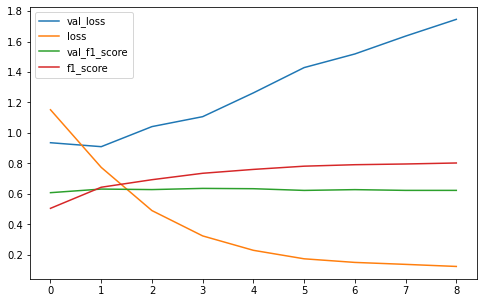

In [435]:
# Babysit the model
pd.DataFrame({'val_loss':history.history['val_loss'],
              'loss':history.history['loss'],
             'val_f1_score':history.history['val_f1_score'],
              'f1_score':history.history['f1_score']}).plot(figsize=(8,5))

<font color='blue'>
* Babysit your model
</font>

The result depends on the parameter 'average' in F1Score.

-  average="macro", F1-Score = in the range [0.40 - 0.42] 
-  average="weighted", F1-Score = in the range [0.59 - 0.61] 



In [436]:
# Evaluate the model
f1.update_state(y_test_enc, model.predict(X_test))
result = f1.result()
result.numpy()

0.6107889